In [1]:
import dash
from dash import dcc, html, Input, Output
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, generate_binary_structure
from sklearn.decomposition import PCA
from skimage.measure import marching_cubes
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import cKDTree
from collections import defaultdict

# Define the folder numbers to process
folder_numbers = ['C0001','C0002','C0003','C0005','C0008','C0018','C0036','C0049','C0004_1','C0004_2','C0074_1','C0074_2']

def process_folder(folder_number):
    # Load the NIfTI file
    file_path = os.path.join(r"D:\Utrecht Studying\Team challenge\Aneurysm_TC_data", folder_number, "corrected_segmentation.nii.gz")
    nii_file = nib.load(file_path)
    seg_data = nii_file.get_fdata()
    
    # Get the coordinates of voxels with values 1 and 2
    x1, y1, z1 = np.where(seg_data == 1)  # Cerebral vessels
    x2, y2, z2 = np.where(seg_data == 2)  # Aneurysms

    # Downsampling function
    def downsample_coordinates(x, y, z, factor=2):
        indices = np.arange(0, len(x), factor)
        return x[indices], y[indices], z[indices]

    # Downsample coordinates
    x1, y1, z1 = downsample_coordinates(x1, y1, z1, factor=1)
    x2, y2, z2 = downsample_coordinates(x2, y2, z2, factor=1)

    # Perform additional dilation on the connection region to make the connection surface thicker
    def find_thick_connection_region(seg_data, iterations=1):
        # Create masks for vessels and aneurysms
        vessels_mask = (seg_data == 1)
        aneurysms_mask = (seg_data == 2)
        
        # Basic dilation to get the initial connection region
        structure = generate_binary_structure(3, 1)  # 3D connectivity structure
        dilated_vessels = binary_dilation(vessels_mask, structure=structure)
        dilated_aneurysms = binary_dilation(aneurysms_mask, structure=structure)
        connection_region = np.logical_and(dilated_vessels, dilated_aneurysms)
        
        x, y, z = np.where(connection_region)
        return x, y, z

    # Use the further dilated connection region
    x, y, z = find_thick_connection_region(seg_data, iterations=1)

    # Calculate the normal vector of the connected region
    def calculate_normal_vector(x, y, z):
        # Combine the coordinates into a set of points
        points = np.vstack((x, y, z)).T
        
        # Use PCA to fit a plane
        pca = PCA(n_components=3)
        pca.fit(points)
        
        # The normal vector is the eigenvector corresponding to the smallest eigenvalue of PCA
        normal_vector = pca.components_[2]
        return normal_vector

    # Calculate the normal vector and center point
    if len(x) > 0:
        normal_vector = calculate_normal_vector(x, y, z)
        center_x, center_y, center_z = np.mean(x), np.mean(y), np.mean(z)
    else:
        normal_vector = np.array([0, 0, 1])  # Default normal vector
        center_x, center_y, center_z = 0, 0, 0  # Default center point

    # Generate mesh for cerebral vessels and aneurysms
    def generate_mesh(seg_data, label):
        mask = (seg_data == label)
        if np.any(mask):
            verts, faces, _, _ = marching_cubes(mask, level=0.5)
            return verts, faces
        return None, None

    # Generate meshes for vessels (label 1) and aneurysms (label 2)
    verts1, faces1 = generate_mesh(seg_data, 1)  # Cerebral vessels
    verts2, faces2 = generate_mesh(seg_data, 2)  # Aneurysms

    # Generate mesh for the (thickened) connected region
    def generate_connection_mesh(x, y, z):
        if len(x) > 0:
            # Create a binary mask for the connected region
            connection_mask = np.zeros_like(seg_data, dtype=bool)
            connection_mask[x, y, z] = True
            
            # Generate mesh using marching cubes
            verts, faces, _, _ = marching_cubes(connection_mask, level=0.5)
            return verts, faces
        return None, None

    # Generate mesh for the connected region
    verts_conn, faces_conn = generate_connection_mesh(x, y, z)

    # Calculate the two basis vectors of the orthogonal plane
    def calculate_orthogonal_plane(normal_vector):
        # Choose a vector that is not parallel to the normal vector
        if normal_vector[0] != 0 or normal_vector[1] != 0:
            base_vector = np.array([0, 0, 1])
        else:
            base_vector = np.array([1, 0, 0])
        
        # Calculate the first orthogonal vector
        u = np.cross(normal_vector, base_vector)
        u /= np.linalg.norm(u)
        
        # Calculate the second orthogonal vector
        v = np.cross(normal_vector, u)
        v /= np.linalg.norm(v)
        
        return u, v

    # Calculate the two basis vectors of the orthogonal plane
    u, v = calculate_orthogonal_plane(normal_vector)

    # Generate points on the plane
    plane_size = 50  # Size of the plane
    plane_points = np.array([[center_x + u[0] * i + v[0] * j,
                              center_y + u[1] * i + v[1] * j,
                              center_z + u[2] * i + v[2] * j]
                             for i in range(-plane_size, plane_size + 1, 10)
                             for j in range(-plane_size, plane_size + 1, 10)])

    # Generate plane indices for Mesh3d
    def generate_plane_indices(plane_size):
        indices = []
        for i in range(plane_size * 2):
            for j in range(plane_size * 2):
                indices.append([i, i + 1, j])
                indices.append([i + 1, j, j + 1])
        return np.array(indices)

    plane_indices = generate_plane_indices(plane_size)

    # Calculate camera view
    def calculate_camera_view(normal_vector, angle, zoom_factor=1.5):
        angle_rad = np.deg2rad(angle)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        u, v = calculate_orthogonal_plane(normal_vector)
        
        # Calculate the eye position based on the angle
        eye = np.cos(angle_rad) * u + np.sin(angle_rad) * v
        eye = eye * zoom_factor
        
        # Camera up direction is the normal vector
        camera_up = normal_vector
        
        # Ensure camera_eye and camera_up are dictionaries
        camera_eye = dict(x=float(eye[0]), y=float(eye[1]), z=float(eye[2]))
        camera_up = dict(x=float(camera_up[0]), y=float(camera_up[1]), z=float(camera_up[2]))
        
        return camera_eye, camera_up

    # Calculate the pitch angle
    def calculate_pitch_angle(normal_vector, camera_eye):
        # Normalize the normal vector and camera eye vector
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        camera_eye = np.array([camera_eye['x'], camera_eye['y'], camera_eye['z']])
        camera_eye = camera_eye / np.linalg.norm(camera_eye)
        
        # Calculate the pitch angle using the dot product
        pitch_angle = np.arccos(np.dot(normal_vector, camera_eye))
        return np.rad2deg(pitch_angle)

    # Adjust camera view based on pitch angle
    def adjust_camera_view(normal_vector, angle, pitch_angle, zoom_factor=1.5):
        angle_rad = np.deg2rad(angle)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        u, v = calculate_orthogonal_plane(normal_vector)
        
        # Calculate the eye position based on the angle and pitch angle
        eye = np.cos(angle_rad) * u + np.sin(angle_rad) * v
        eye = eye * zoom_factor
        
        # Adjust the camera up direction based on the pitch angle
        pitch_rad = np.deg2rad(pitch_angle)
        camera_up = normal_vector * np.cos(pitch_rad) + np.cross(eye, normal_vector) * np.sin(pitch_rad)
        
        # Ensure camera_eye and camera_up are dictionaries
        camera_eye = dict(x=float(eye[0]), y=float(eye[1]), z=float(eye[2]))
        camera_up = dict(x=float(camera_up[0]), y=float(camera_up[1]), z=float(camera_up[2]))
        
        return camera_eye, camera_up

    # Project 3D points to 2D
    def project_to_2d(x, y, z, camera_eye, camera_up):
        camera_eye = np.array([camera_eye['x'], camera_eye['y'], camera_eye['z']])
        camera_up = np.array([camera_up['x'], camera_up['y'], camera_up['z']])
        
        # Normalize camera_eye and camera_up
        camera_eye = camera_eye / np.linalg.norm(camera_eye)
        camera_up = camera_up / np.linalg.norm(camera_up)
        
        # Calculate the right vector (orthogonal to camera_up and camera_eye)
        right = np.cross(camera_up, camera_eye)
        right = right / np.linalg.norm(right)
        
        # Calculate the up vector (orthogonal to camera_eye and right)
        up = np.cross(camera_eye, right)
        up = up / np.linalg.norm(up)
        
        # Stack the 3D points
        points = np.column_stack([x, y, z])
        
        # Project points onto the 2D plane
        projected_x = np.dot(points, right)
        projected_y = np.dot(points, up)
        
        # Calculate depth (distance from camera)
        depth = np.dot(points - camera_eye, camera_eye)
        
        # Handle NaN values
        projected_x = np.nan_to_num(projected_x, nan=0)
        projected_y = np.nan_to_num(projected_y, nan=0)
        depth = np.nan_to_num(depth, nan=0)
        
        return projected_x, projected_y, depth

    def calculate_azimuth_elevation(camera_eye):
        azimuth = np.arctan2(camera_eye['y'], camera_eye['x']) * 180 / np.pi
        elevation = np.arctan2(camera_eye['z'], np.sqrt(camera_eye['x']**2 + camera_eye['y']**2)) * 180 / np.pi
        return azimuth, elevation

    def save_2d_projection_matplotlib(angle, azimuth, elevation, camera_eye, save_path):
        # Generate the figures - now expecting 4 return values
        fig_3d, fig_2d_overlap, fig_2d_no_overlap, _ = update_plots(angle, ['vessels', 'aneurysms', 'connection', 'plane'])
        
        # Rest of the function remains the same...
        # Extract projection data for the overlap plot (first trace in fig_2d_overlap)
        data_overlap = fig_2d_overlap.data[0]  # The first trace is the projection data with overlap
        x_overlap = data_overlap['x']
        y_overlap = data_overlap['y']
        colors_overlap = data_overlap['marker']['color']
        
        # Create a matplotlib image for the overlap plot
        plt.figure(figsize=(8, 8))  # Increased figure size for clarity
        plt.scatter(x_overlap, y_overlap, c=colors_overlap, s=8, alpha=1.0)  # Fully opaque
        plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio

        # Ensure axis limits are equal to prevent stretching
        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        max_range = max(x_max - x_min, y_max - y_min)
        mid_x = (x_max + x_min) / 2
        mid_y = (y_max + y_min) / 2
        plt.xlim(mid_x - max_range / 2, mid_x + max_range / 2)
        plt.ylim(mid_y - max_range / 2, mid_y + max_range / 2)

        plt.axis('off')  # Disable axes
        plt.tight_layout()

        # Save the overlap plot
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        filename = f"2d_projection_overlap_angle_{angle}.png"
        plt.savefig(os.path.join(save_path, filename), bbox_inches=None, pad_inches=0, dpi=700)
        plt.close()

        # Extract projection data for the no-overlap plot (second trace in fig_2d_no_overlap)
        data_no_overlap = fig_2d_no_overlap.data[0]  # The first trace is the projection data without overlap
        x_no_overlap = data_no_overlap['x']
        y_no_overlap = data_no_overlap['y']
        colors_no_overlap = data_no_overlap['marker']['color']
        
        # Create a matplotlib image for the no-overlap plot
        plt.figure(figsize=(8, 8))  # Increased figure size for clarity
        plt.scatter(x_no_overlap, y_no_overlap, c=colors_no_overlap, s=8, alpha=1.0)  # Fully opaque
        plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio

        # Ensure axis limits are equal to prevent stretching
        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        max_range = max(x_max - x_min, y_max - y_min)
        mid_x = (x_max + x_min) / 2
        mid_y = (y_max + y_min) / 2
        plt.xlim(mid_x - max_range / 2, mid_x + max_range / 2)
        plt.ylim(mid_y - max_range / 2, mid_y + max_range / 2)

        plt.axis('off')  # Disable axes
        plt.tight_layout()

        # Save the no-overlap plot
        filename_no_overlap = f"2d_projection_no_overlap_angle_{angle}.png"
        plt.savefig(os.path.join(save_path, filename_no_overlap), bbox_inches=None, pad_inches=0, dpi=700)
        plt.close()

        # Save camera information to text file
        camera_info = {
            'angle': angle,
            'azimuth': azimuth,
            'elevation': elevation,
            'camera_eye_x': camera_eye['x'],
            'camera_eye_y': camera_eye['y'],
            'camera_eye_z': camera_eye['z']
        }
        
        # Write to text file
        info_file_path = os.path.join(save_path, "camera_info.txt")
        with open(info_file_path, 'a') as f:
            f.write(f"Angle: {angle}°, Azimuth: {azimuth:.2f}°, Elevation: {elevation:.2f}°, "
                    f"Camera Eye: ({camera_eye['x']:.2f}, {camera_eye['y']:.2f}, {camera_eye['z']:.2f})\n")

    def update_plots(angle, visible_structures):
        fig_3d = go.Figure()
        fig_2d_overlap = go.Figure()
        fig_2d_no_overlap = go.Figure()

        # Add cerebral vessels
        if 'vessels' in visible_structures and verts1 is not None and faces1 is not None:
            fig_3d.add_trace(go.Mesh3d(
                x=verts1[:, 0], y=verts1[:, 1], z=verts1[:, 2],
                i=faces1[:, 0], j=faces1[:, 1], k=faces1[:, 2],
                color='red',
                opacity=0.5,
                name="Cerebral Vessels (Label 1)"
            ))

        # Add aneurysms
        if 'aneurysms' in visible_structures and verts2 is not None and faces2 is not None:
            fig_3d.add_trace(go.Mesh3d(
                x=verts2[:, 0], y=verts2[:, 1], z=verts2[:, 2],
                i=faces2[:, 0], j=faces2[:, 1], k=faces2[:, 2],
                color='blue',
                opacity=0.5,
                name="Aneurysms (Label 2)"
            ))

        # Add connection region
        if 'connection' in visible_structures and verts_conn is not None and faces_conn is not None:
            fig_3d.add_trace(go.Mesh3d(
                x=verts_conn[:, 0], y=verts_conn[:, 1], z=verts_conn[:, 2],
                i=faces_conn[:, 0], j=faces_conn[:, 1], k=faces_conn[:, 2],
                color='green',
                opacity=0.5,
                name="Connection Region"
            ))

        # Add orthogonal plane
        if 'plane' in visible_structures:
            fig_3d.add_trace(go.Mesh3d(
                x=plane_points[:, 0], y=plane_points[:, 1], z=plane_points[:, 2],
                i=plane_indices[:, 0], j=plane_indices[:, 1], k=plane_indices[:, 2],
                color='yellow',
                opacity=0.5,
                name="Orthogonal Plane"
            ))

        # Add normal vector
        if len(x) > 0:
            start_point = np.array([center_x, center_y, center_z])
            end_point = start_point + normal_vector * 50
            fig_3d.add_trace(go.Scatter3d(
                x=[start_point[0], end_point[0]],
                y=[start_point[1], end_point[1]],
                z=[start_point[2], end_point[2]],
                mode='lines',
                line=dict(color='purple', width=3),
                name="Normal Vector"
            ))

        # Calculate camera view
        camera_eye, camera_up = calculate_camera_view(normal_vector, angle, zoom_factor=2)
        pitch_angle = calculate_pitch_angle(normal_vector, camera_eye)
        camera_eye, camera_up = adjust_camera_view(normal_vector, angle, pitch_angle, zoom_factor=2)

        # Project points to 2D
        projected_x1, projected_y1, depth1 = project_to_2d(x1, y1, z1, camera_eye, camera_up)
        projected_x2, projected_y2, depth2 = project_to_2d(x2, y2, z2, camera_eye, camera_up)

        if verts_conn is not None:
            projected_x_conn, projected_y_conn, depth_conn = project_to_2d(verts_conn[:, 0], verts_conn[:, 1], verts_conn[:, 2], camera_eye, camera_up)
        else:
            projected_x_conn, projected_y_conn, depth_conn = np.array([]), np.array([]), np.array([])

        # Combine all points with their labels and depths
        all_points = np.concatenate([
            np.column_stack((projected_x1, projected_y1, depth1, np.zeros_like(depth1))),  # Label 0: Cerebral vessels
            np.column_stack((projected_x2, projected_y2, depth2, np.ones_like(depth2))),   # Label 1: Aneurysms
            np.column_stack((projected_x_conn, projected_y_conn, depth_conn, 2 * np.ones_like(depth_conn)))  # Label 2: Connection region
        ])
        sorted_indices = np.argsort(-all_points[:, 2])  # Sort by depth (descending order)
        sorted_points = all_points[sorted_indices]
        
        # Use KDTree for faster overlap detection
        tree = cKDTree(sorted_points[:, :2])
        overlapping_indices_vessels_aneurysms = set()  # For vessels + aneurysms overlap (pink)
        overlapping_indices_vessels_connection = set()  # For vessels + connection overlap (gold)

        for i, point in enumerate(sorted_points[:, :2]):
            neighbors = tree.query_ball_point(point, r=0.3)  # Adjust radius as needed
            if len(neighbors) > 1:
                # Get labels of neighboring points
                labels = sorted_points[neighbors, 3]
                unique_labels = np.unique(labels)
                
                # Check for vessels + aneurysms overlap
                if 0 in unique_labels and 1 in unique_labels:
                    overlapping_indices_vessels_aneurysms.update(neighbors)
                
                # Check for vessels + connection overlap
                if 0 in unique_labels and 2 in unique_labels:
                    overlapping_indices_vessels_connection.update(neighbors)

        # Assign colors
        color_map = {0: 'red', 1: 'blue', 2: 'green'}
        colors = np.array([color_map[label] for label in sorted_points[:, 3]])

        # Mark overlapping points
        if len(overlapping_indices_vessels_aneurysms) > 0:
            colors[list(overlapping_indices_vessels_aneurysms)] = 'pink'  # Vessels + aneurysms overlap
        if len(overlapping_indices_vessels_connection) > 0:
            colors[list(overlapping_indices_vessels_connection)] = 'gold'  # Vessels + connection overlap

        # Add 2D projection with overlap after sorting
        fig_2d_overlap.add_trace(go.Scatter(
            x=sorted_points[:, 0],
            y=sorted_points[:, 1],
            mode='markers',
            marker=dict(size=6, color=colors),
            name='2D Projection (With Overlap)'
        ))

        # Add legend traces for the overlap plot
        fig_2d_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='red'),
            name="Cerebral Vessels"
        ))
        fig_2d_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='blue'),
            name="Aneurysms"
        ))
        fig_2d_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='green'),
            name="Connection Region"
        ))
        fig_2d_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='pink'),
            name="Overlap (Vessels + Aneurysms)"
        ))
        fig_2d_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='gold'),
            name="Overlap (Vessels + Connection)"
        ))

        # Set aspect ratio to equal for the overlap plot
        fig_2d_overlap.update_layout(
            xaxis=dict(scaleanchor="y"),  # This ensures that the x and y axes have the same scale
            yaxis=dict(scaleanchor="x"),
        )

        # Assign colors without overlap (no pink color)
        colors_sorted = np.array([color_map[label] for label in sorted_points[:, 3]])

        # Add 2D projection without overlap
        fig_2d_no_overlap.add_trace(go.Scatter(
            x=sorted_points[:, 0],
            y=sorted_points[:, 1],
            mode='markers',
            marker=dict(size=2, color=colors_sorted),
            name='2D Projection (No Overlap, Sorted by Depth)'
        ))

        # Add legend traces for the no-overlap plot
        fig_2d_no_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='red'),
            name="Cerebral Vessels"
        ))
        fig_2d_no_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='blue'),
            name="Aneurysms"
        ))
        fig_2d_no_overlap.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=2, color='green'),
            name="Connection Region"
        ))

        # Set aspect ratio to equal for the no-overlap plot
        fig_2d_no_overlap.update_layout(
            xaxis=dict(scaleanchor="y"),  # This ensures that the x and y axes have the same scale
            yaxis=dict(scaleanchor="x"),
        )

        # Update 3D layout
        fig_3d.update_layout(
            scene=dict(
                xaxis=dict(title='X'),
                yaxis=dict(title='Y'),
                zaxis=dict(title='Z'),
                camera=dict(
                    eye=dict(x=camera_eye['x'], y=camera_eye['y'], z=camera_eye['z']),
                    up=dict(x=camera_up['x'], y=camera_up['y'], z=camera_up['z'])
                )
            ),
            title="3D Projection"
        )

        return fig_3d, fig_2d_overlap, fig_2d_no_overlap, camera_eye

    # Process each angle for this folder
    save_path = os.path.join(r"D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2", folder_number + "_saved_images")
    
    # Create or clear the camera info file at the beginning
    info_file_path = os.path.join(save_path, "camera_info.txt")
    if os.path.exists(info_file_path):
        os.remove(info_file_path)
    
    for angle in range(0, 361, 10):
        # Calculate camera view
        camera_eye, _ = calculate_camera_view(normal_vector, angle, zoom_factor=2)
        azimuth, elevation = calculate_azimuth_elevation(camera_eye)
        
        # Save the 2D projections and camera info
        save_2d_projection_matplotlib(angle, azimuth, elevation, camera_eye, save_path)

# Process all folders
for folder_number in folder_numbers:
    print(f"Processing folder: {folder_number}")
    process_folder(folder_number)
    print(f"Finished processing folder: {folder_number}")

print("All folders processed successfully!")

Processing folder: C0001
Finished processing folder: C0001
Processing folder: C0002
Finished processing folder: C0002
Processing folder: C0003
Finished processing folder: C0003
Processing folder: C0005
Finished processing folder: C0005
Processing folder: C0008
Finished processing folder: C0008
Processing folder: C0018
Finished processing folder: C0018
Processing folder: C0036
Finished processing folder: C0036
Processing folder: C0049
Finished processing folder: C0049
Processing folder: C0004_1
Finished processing folder: C0004_1
Processing folder: C0004_2
Finished processing folder: C0004_2
Processing folder: C0074_1
Finished processing folder: C0074_1
Processing folder: C0074_2
Finished processing folder: C0074_2
All folders processed successfully!



Processing folder: C0001

Shortest Connection: 2d_projection_no_overlap_angle_150.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0001_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_150.png
Saved No Overlap (Shortest Connection) successfully.


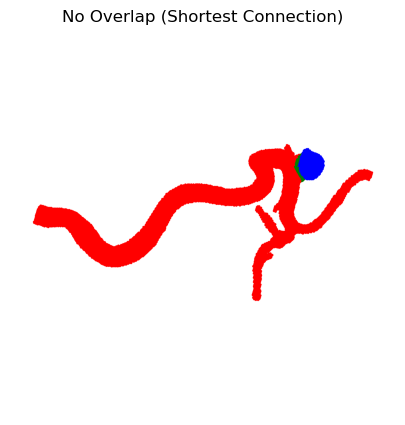

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0001_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_150.png
Saved Overlap (Shortest Connection) successfully.


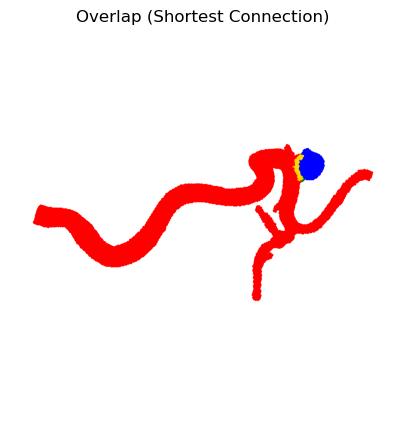


Longest Connection: 2d_projection_no_overlap_angle_0.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0001_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_0.png
Saved No Overlap (Longest Connection) successfully.


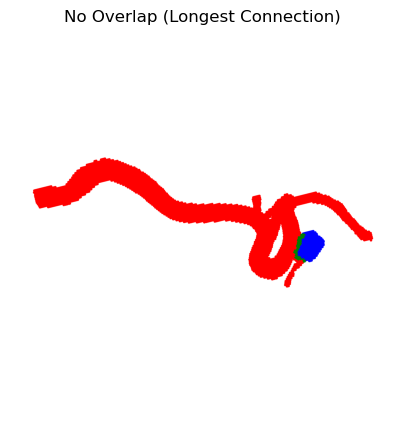

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0001_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_0.png
Saved Overlap (Longest Connection) successfully.


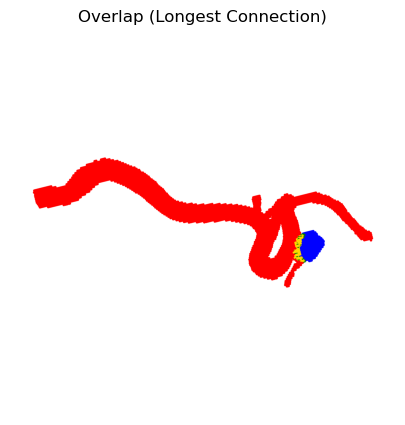


Largest Aneurysm: 2d_projection_no_overlap_angle_150.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0001_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_150.png
Saved No Overlap (Largest Aneurysm) successfully.


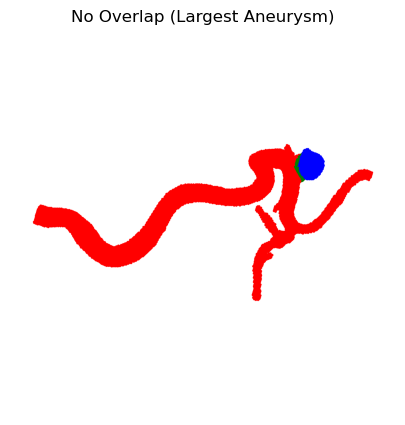

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0001_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_150.png
Saved Overlap (Largest Aneurysm) successfully.


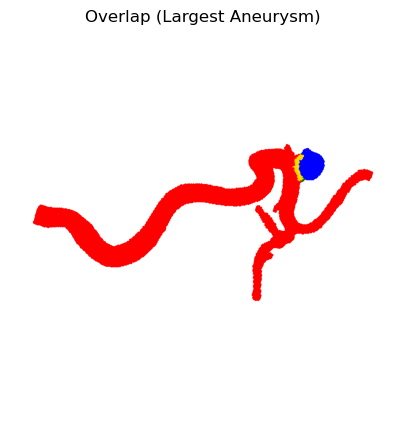


Processing folder: C0002

Shortest Connection: 2d_projection_no_overlap_angle_110.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0002_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_110.png
Saved No Overlap (Shortest Connection) successfully.


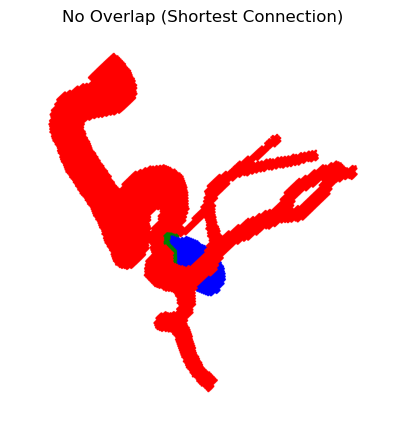

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0002_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_110.png
Saved Overlap (Shortest Connection) successfully.


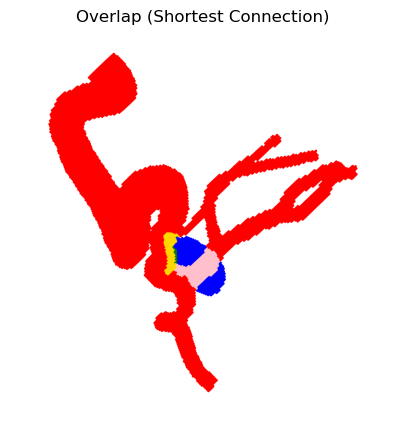


Longest Connection: 2d_projection_no_overlap_angle_330.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0002_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_330.png
Saved No Overlap (Longest Connection) successfully.


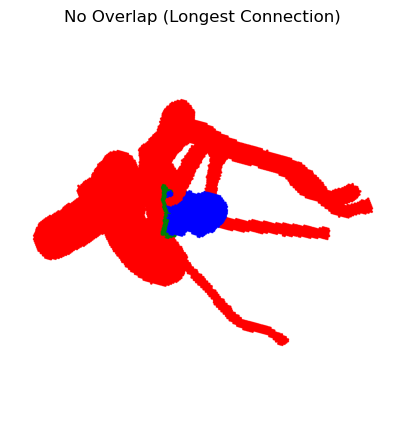

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0002_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_330.png
Saved Overlap (Longest Connection) successfully.


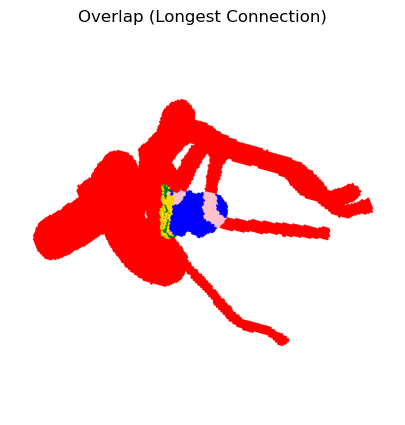


Largest Aneurysm: 2d_projection_no_overlap_angle_330.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0002_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_330.png
Saved No Overlap (Largest Aneurysm) successfully.


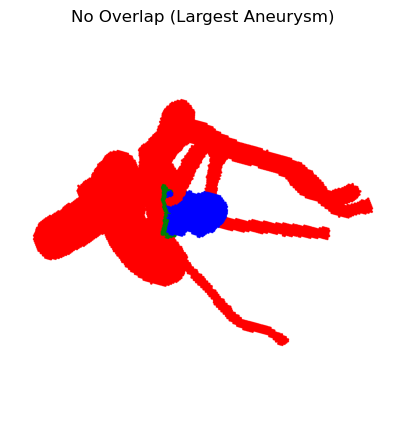

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0002_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_330.png
Saved Overlap (Largest Aneurysm) successfully.


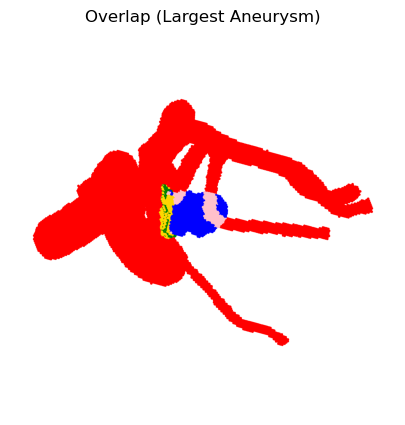


Processing folder: C0003

Shortest Connection: 2d_projection_no_overlap_angle_330.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0003_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_330.png
Saved No Overlap (Shortest Connection) successfully.


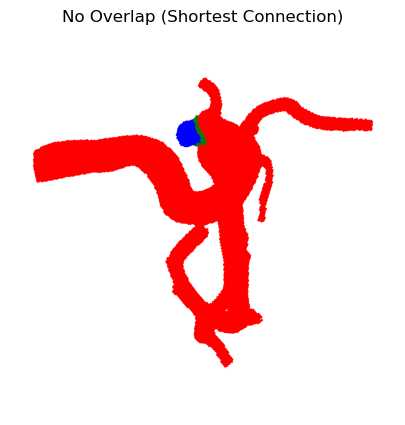

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0003_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_330.png
Saved Overlap (Shortest Connection) successfully.


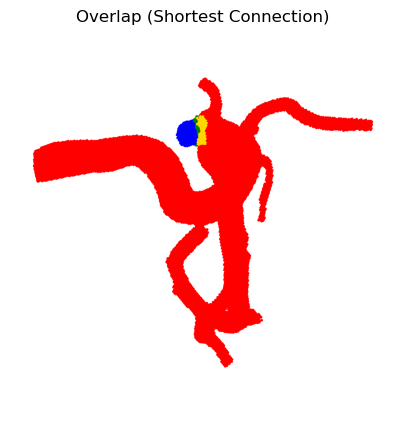


Longest Connection: 2d_projection_no_overlap_angle_140.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0003_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_140.png
Saved No Overlap (Longest Connection) successfully.


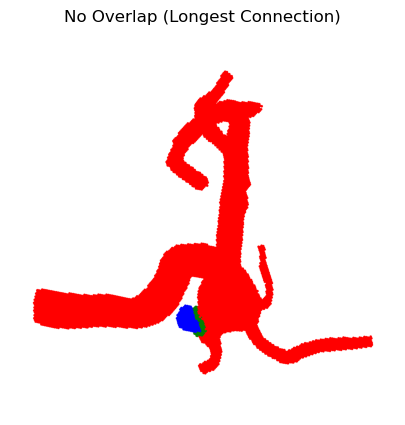

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0003_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_140.png
Saved Overlap (Longest Connection) successfully.


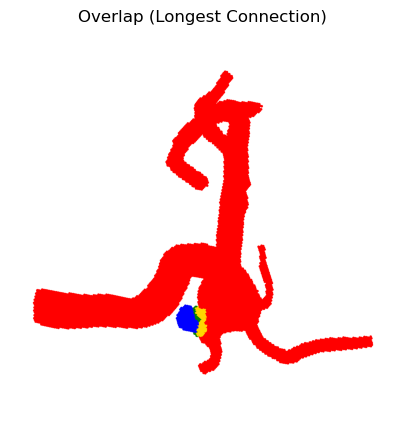


Largest Aneurysm: 2d_projection_no_overlap_angle_320.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0003_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_320.png
Saved No Overlap (Largest Aneurysm) successfully.


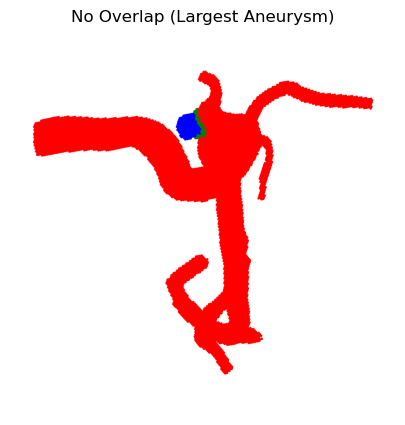

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0003_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_320.png
Saved Overlap (Largest Aneurysm) successfully.


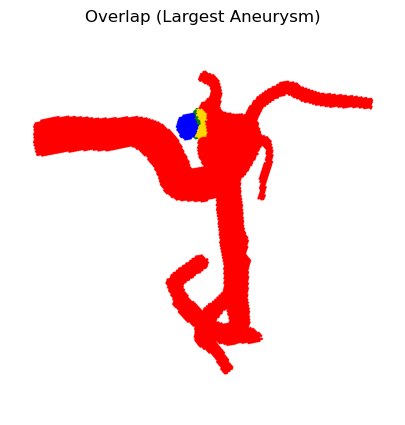


Processing folder: C0005

Shortest Connection: 2d_projection_no_overlap_angle_20.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0005_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_20.png
Saved No Overlap (Shortest Connection) successfully.


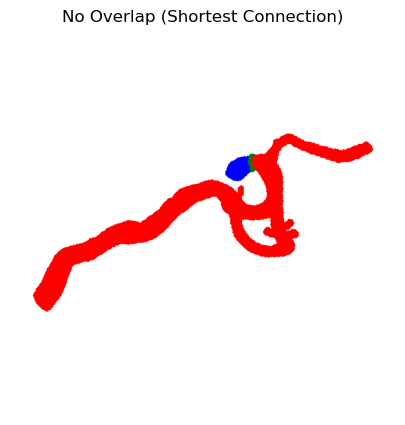

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0005_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_20.png
Saved Overlap (Shortest Connection) successfully.


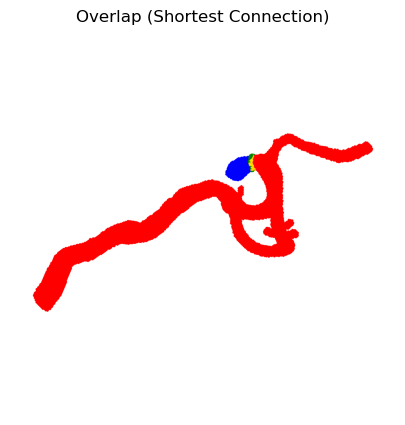


Longest Connection: 2d_projection_no_overlap_angle_100.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0005_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_100.png
Saved No Overlap (Longest Connection) successfully.


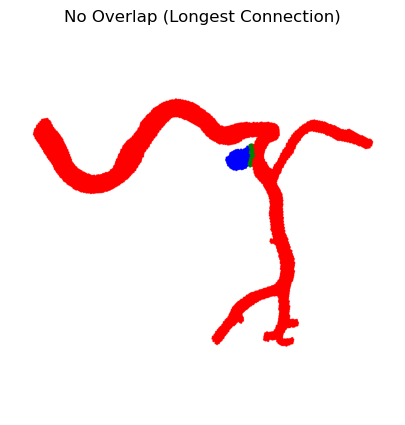

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0005_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_100.png
Saved Overlap (Longest Connection) successfully.


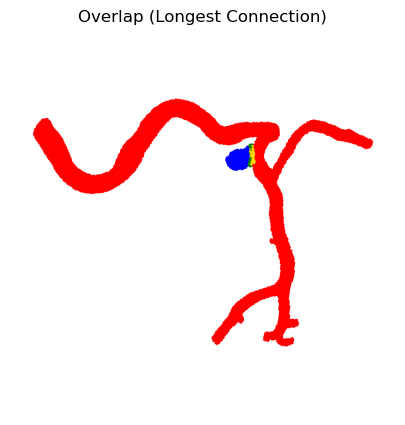


Largest Aneurysm: 2d_projection_no_overlap_angle_20.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0005_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_20.png
Saved No Overlap (Largest Aneurysm) successfully.


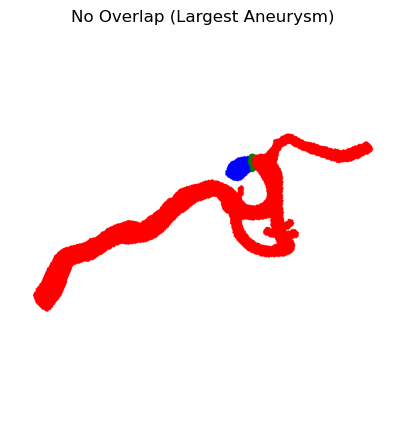

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0005_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_20.png
Saved Overlap (Largest Aneurysm) successfully.


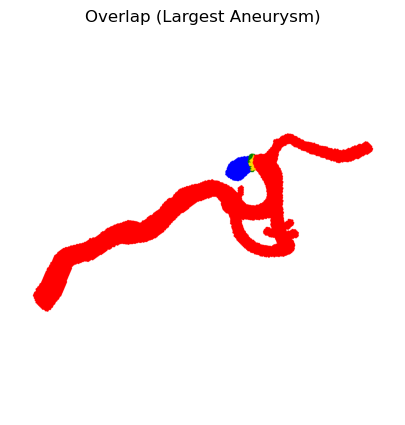


Processing folder: C0008

Shortest Connection: 2d_projection_no_overlap_angle_210.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0008_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_210.png
Saved No Overlap (Shortest Connection) successfully.


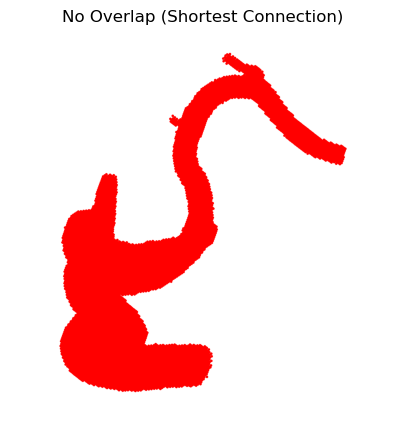

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0008_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_210.png
Saved Overlap (Shortest Connection) successfully.


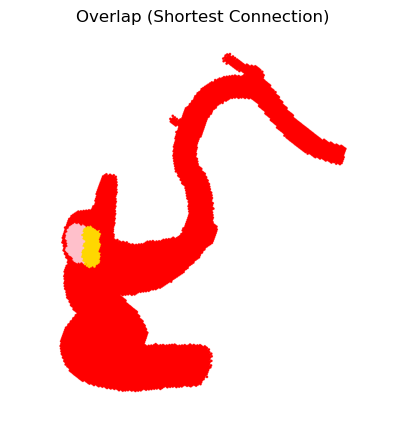


Longest Connection: 2d_projection_no_overlap_angle_150.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0008_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_150.png
Saved No Overlap (Longest Connection) successfully.


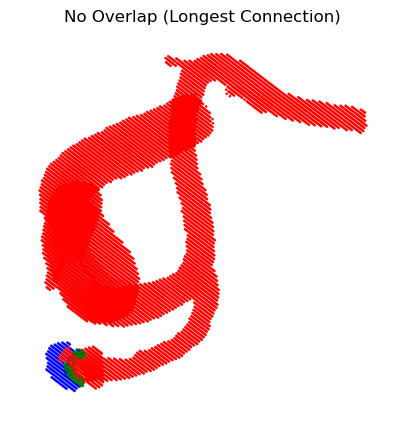

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0008_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_150.png
Saved Overlap (Longest Connection) successfully.


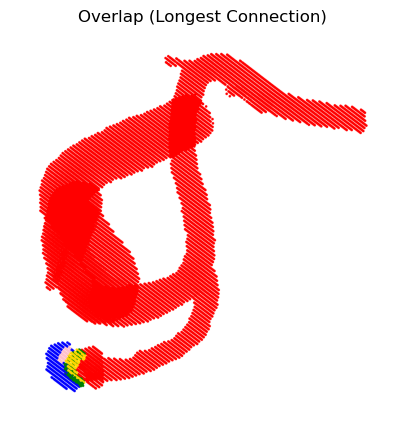


Largest Aneurysm: 2d_projection_no_overlap_angle_160.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0008_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_160.png
Saved No Overlap (Largest Aneurysm) successfully.


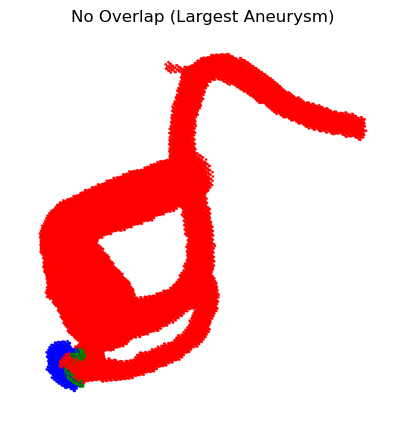

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0008_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_160.png
Saved Overlap (Largest Aneurysm) successfully.


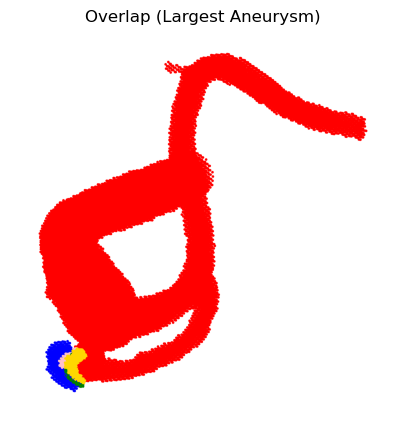


Processing folder: C0018

Shortest Connection: 2d_projection_no_overlap_angle_200.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0018_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_200.png
Saved No Overlap (Shortest Connection) successfully.


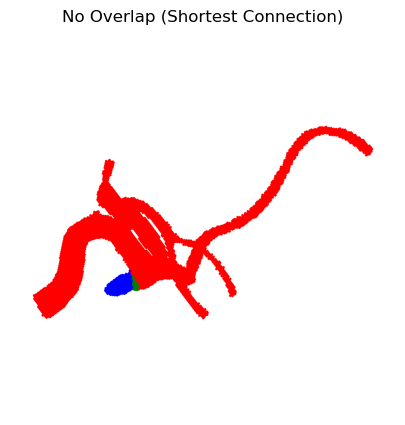

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0018_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_200.png
Saved Overlap (Shortest Connection) successfully.


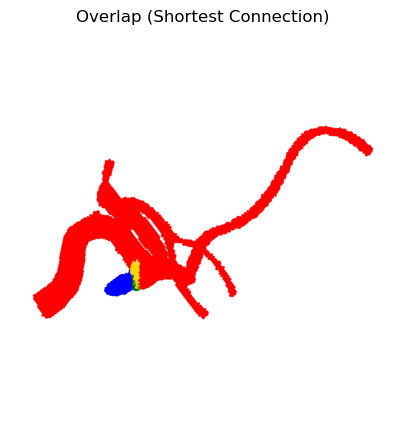


Longest Connection: 2d_projection_no_overlap_angle_100.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0018_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_100.png
Saved No Overlap (Longest Connection) successfully.


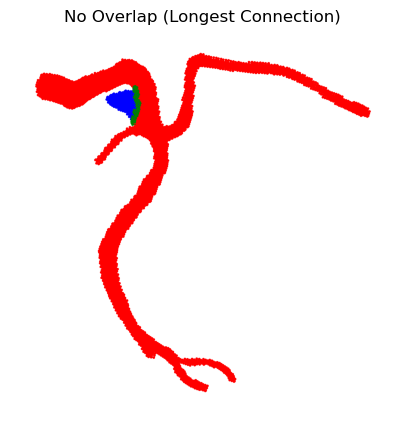

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0018_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_100.png
Saved Overlap (Longest Connection) successfully.


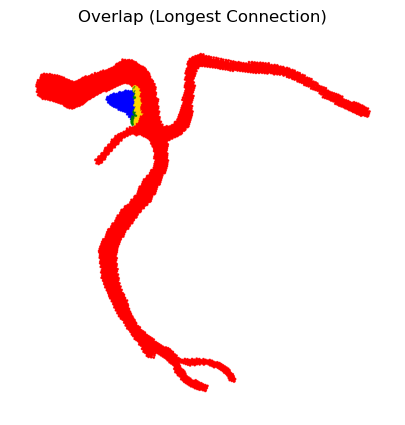


Largest Aneurysm: 2d_projection_no_overlap_angle_100.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0018_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_100.png
Saved No Overlap (Largest Aneurysm) successfully.


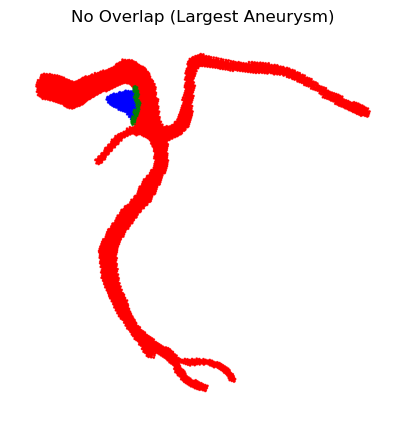

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0018_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_100.png
Saved Overlap (Largest Aneurysm) successfully.


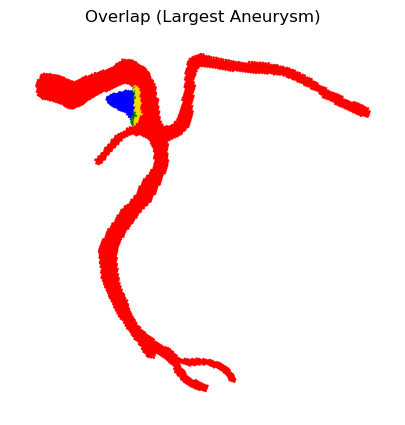


Processing folder: C0036

Shortest Connection: 2d_projection_no_overlap_angle_140.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0036_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_140.png
Saved No Overlap (Shortest Connection) successfully.


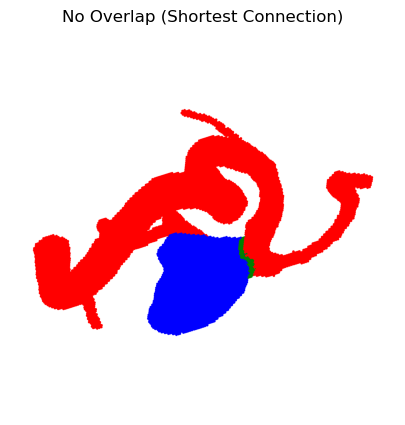

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0036_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_140.png
Saved Overlap (Shortest Connection) successfully.


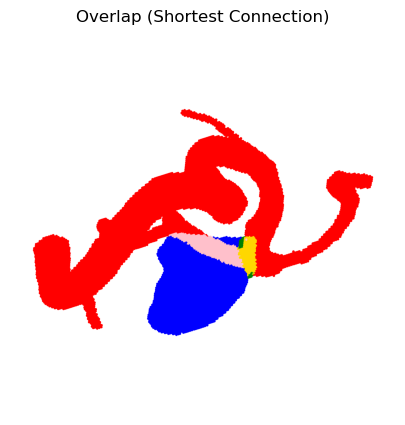


Longest Connection: 2d_projection_no_overlap_angle_280.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0036_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_280.png
Saved No Overlap (Longest Connection) successfully.


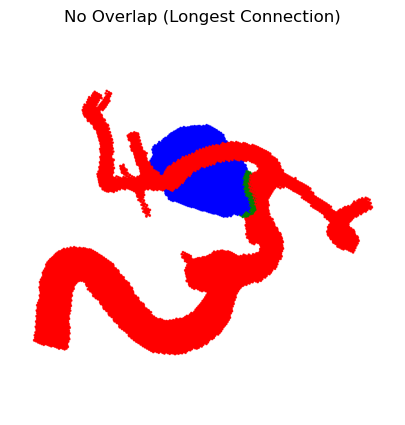

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0036_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_280.png
Saved Overlap (Longest Connection) successfully.


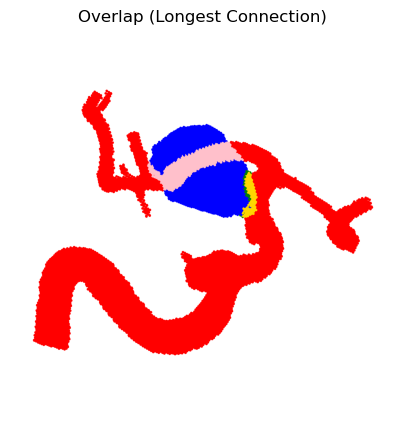


Largest Aneurysm: 2d_projection_no_overlap_angle_140.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0036_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_140.png
Saved No Overlap (Largest Aneurysm) successfully.


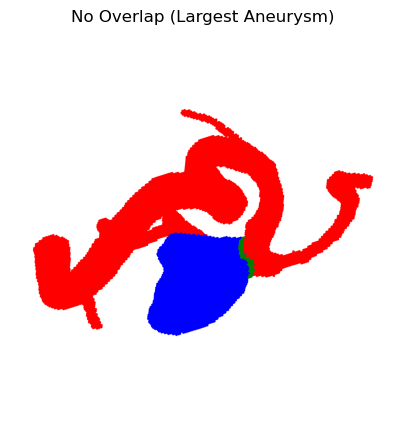

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0036_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_140.png
Saved Overlap (Largest Aneurysm) successfully.


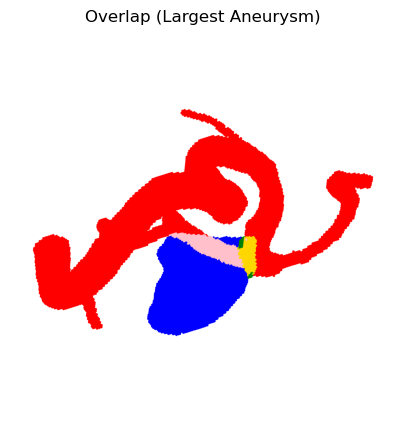


Processing folder: C0049

Shortest Connection: 2d_projection_no_overlap_angle_50.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0049_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_50.png
Saved No Overlap (Shortest Connection) successfully.


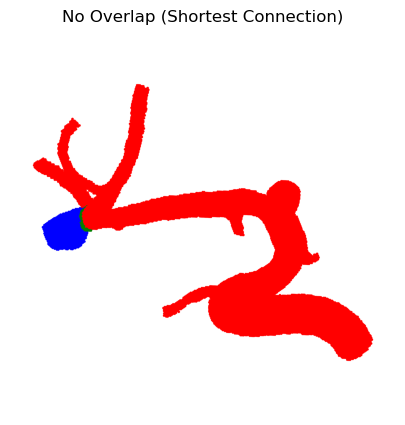

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0049_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_50.png
Saved Overlap (Shortest Connection) successfully.


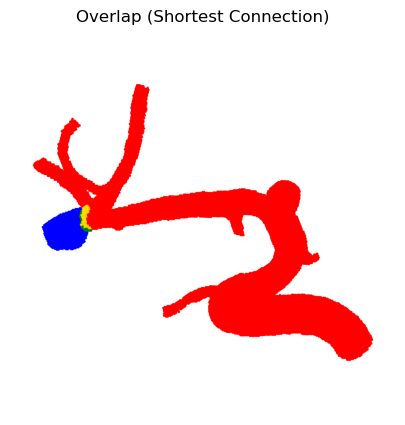


Longest Connection: 2d_projection_no_overlap_angle_130.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0049_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_130.png
Saved No Overlap (Longest Connection) successfully.


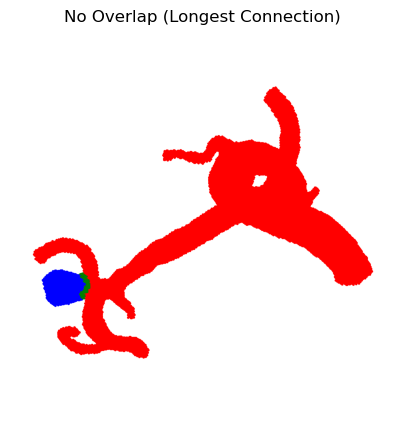

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0049_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_130.png
Saved Overlap (Longest Connection) successfully.


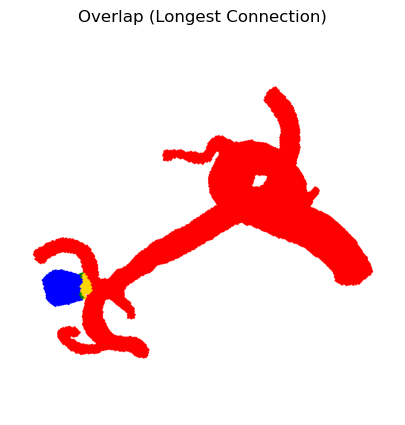


Largest Aneurysm: 2d_projection_no_overlap_angle_50.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0049_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_50.png
Saved No Overlap (Largest Aneurysm) successfully.


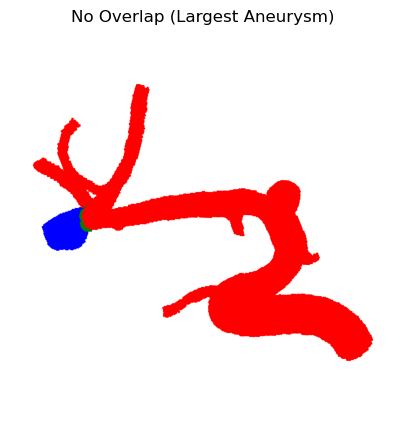

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0049_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_50.png
Saved Overlap (Largest Aneurysm) successfully.


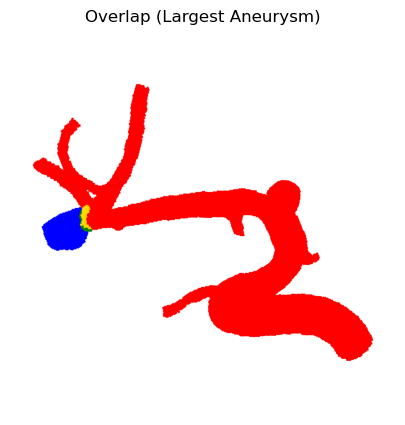


Processing folder: C0004_1

Shortest Connection: 2d_projection_no_overlap_angle_240.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_1_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_240.png
Saved No Overlap (Shortest Connection) successfully.


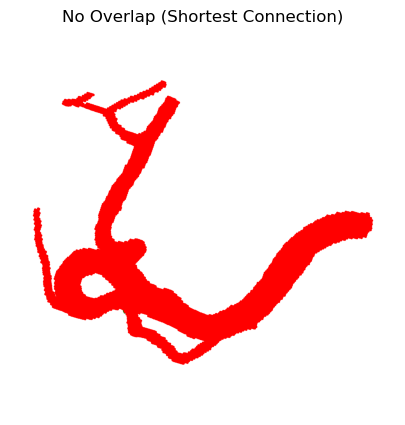

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_1_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_240.png
Saved Overlap (Shortest Connection) successfully.


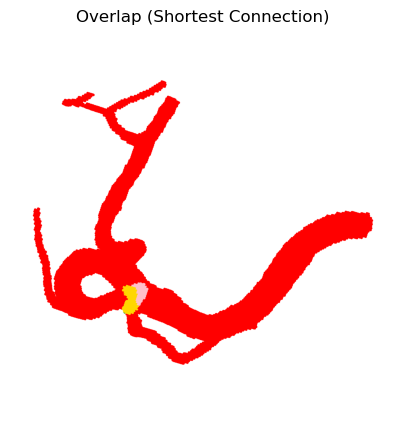


Longest Connection: 2d_projection_no_overlap_angle_130.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_1_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_130.png
Saved No Overlap (Longest Connection) successfully.


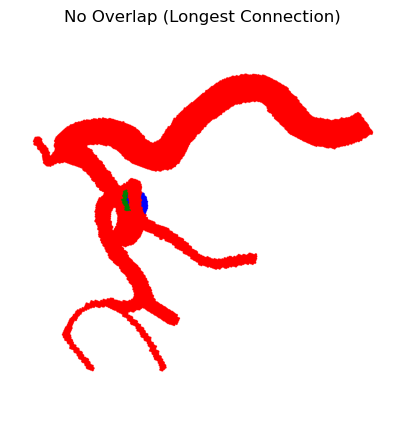

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_1_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_130.png
Saved Overlap (Longest Connection) successfully.


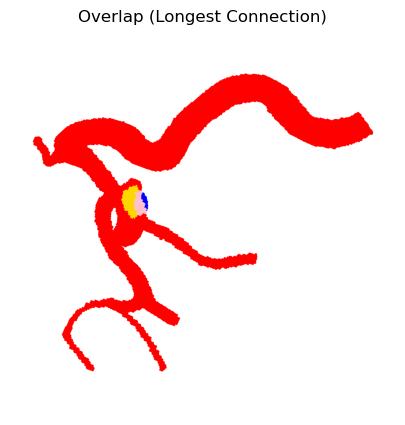


Largest Aneurysm: 2d_projection_no_overlap_angle_180.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_1_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_180.png
Saved No Overlap (Largest Aneurysm) successfully.


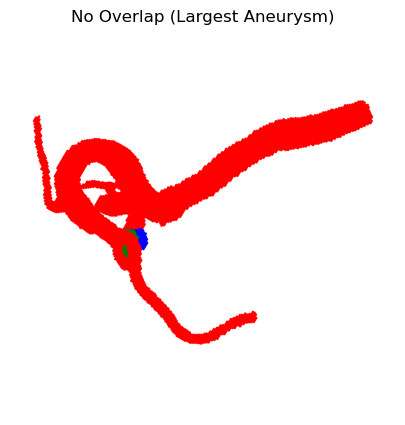

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_1_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_180.png
Saved Overlap (Largest Aneurysm) successfully.


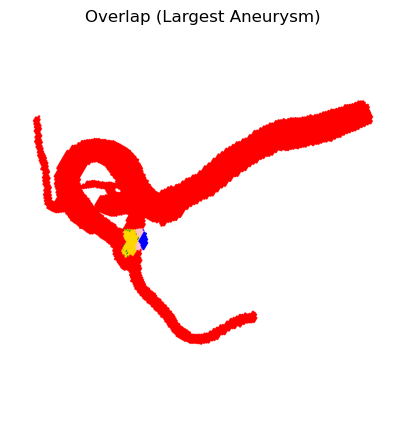


Processing folder: C0004_2

Shortest Connection: 2d_projection_no_overlap_angle_210.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_2_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_210.png
Saved No Overlap (Shortest Connection) successfully.


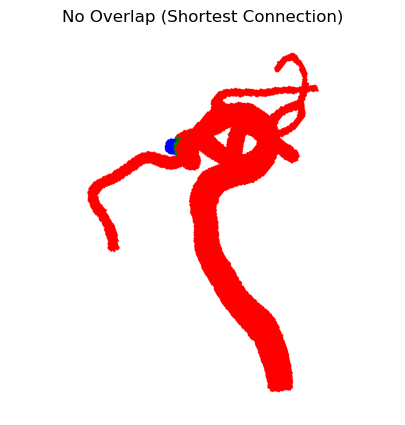

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_2_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_210.png
Saved Overlap (Shortest Connection) successfully.


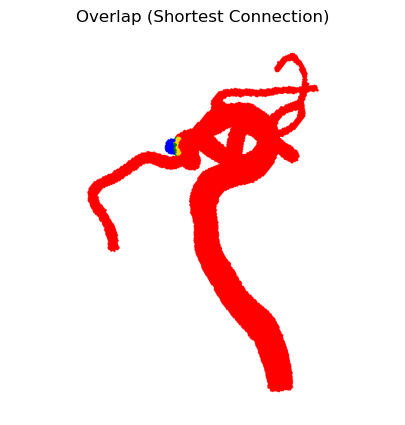


Longest Connection: 2d_projection_no_overlap_angle_120.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_2_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_120.png
Saved No Overlap (Longest Connection) successfully.


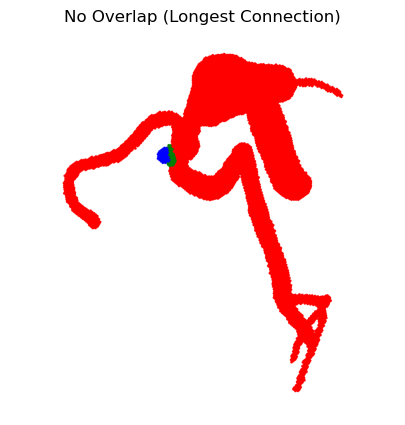

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_2_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_120.png
Saved Overlap (Longest Connection) successfully.


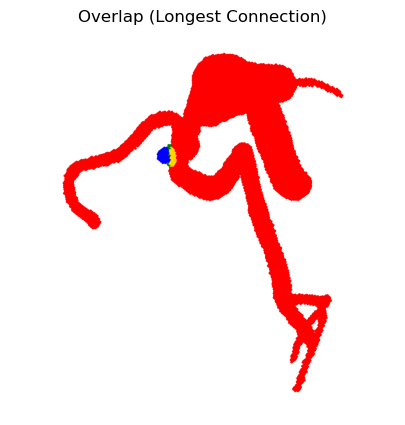


Largest Aneurysm: 2d_projection_no_overlap_angle_120.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_2_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_120.png
Saved No Overlap (Largest Aneurysm) successfully.


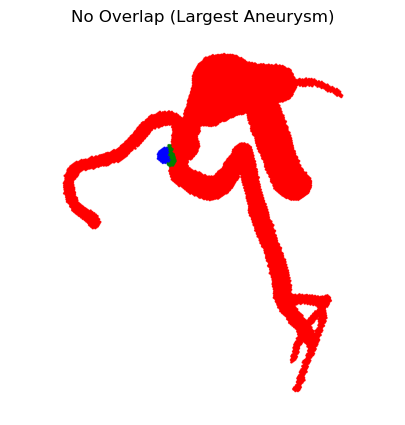

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0004_2_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_120.png
Saved Overlap (Largest Aneurysm) successfully.


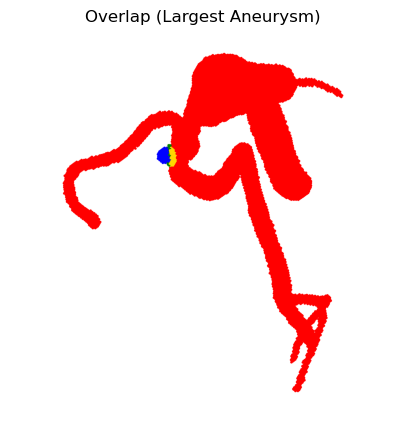


Processing folder: C0074_1

Shortest Connection: 2d_projection_no_overlap_angle_10.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_1_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_10.png
Saved No Overlap (Shortest Connection) successfully.


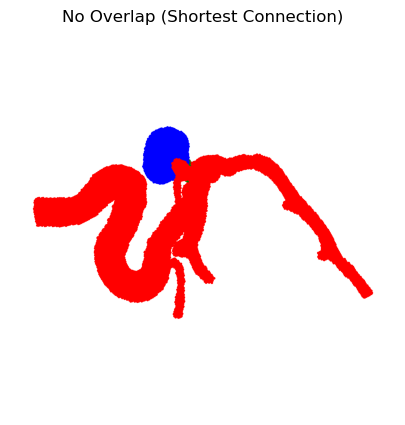

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_1_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_10.png
Saved Overlap (Shortest Connection) successfully.


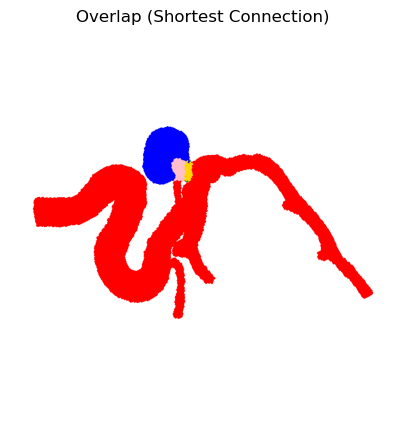


Longest Connection: 2d_projection_no_overlap_angle_320.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_1_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_320.png
Saved No Overlap (Longest Connection) successfully.


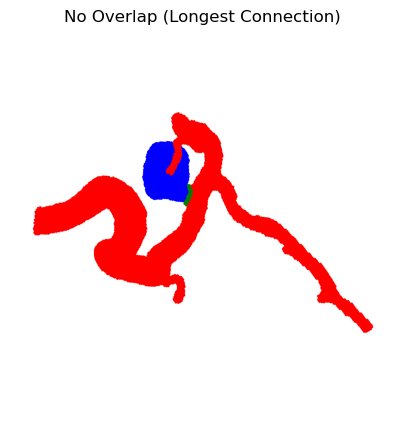

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_1_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_320.png
Saved Overlap (Longest Connection) successfully.


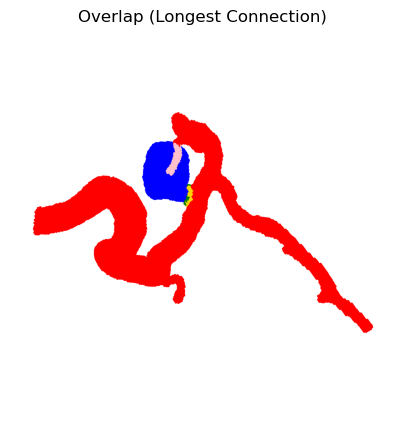


Largest Aneurysm: 2d_projection_no_overlap_angle_140.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_1_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_140.png
Saved No Overlap (Largest Aneurysm) successfully.


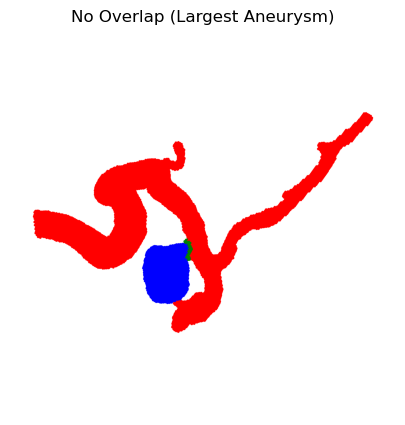

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_1_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_140.png
Saved Overlap (Largest Aneurysm) successfully.


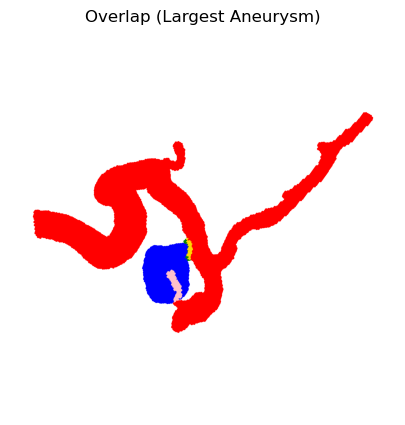


Processing folder: C0074_2

Shortest Connection: 2d_projection_no_overlap_angle_340.png
Saving No Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_2_saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_340.png
Saved No Overlap (Shortest Connection) successfully.


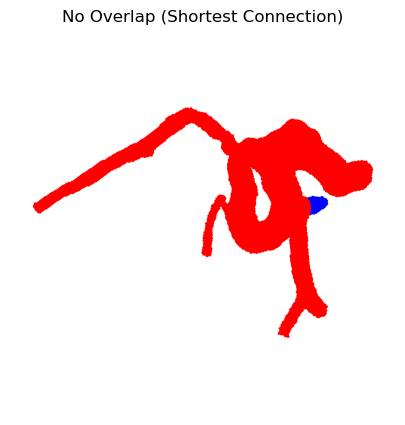

Saving Overlap (Shortest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_2_saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_340.png
Saved Overlap (Shortest Connection) successfully.


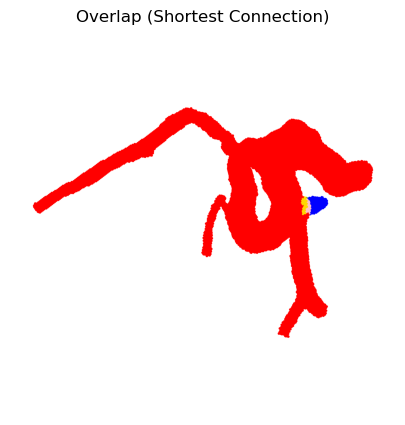


Longest Connection: 2d_projection_no_overlap_angle_100.png
Saving No Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_2_saved_images\optimal\No_Overlap_(Longest_Connection)_no_overlap_angle_100.png
Saved No Overlap (Longest Connection) successfully.


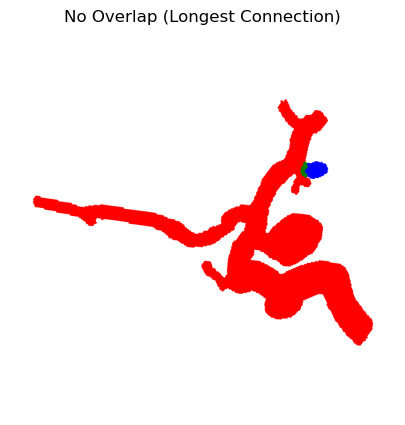

Saving Overlap (Longest Connection) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_2_saved_images\optimal\Overlap_(Longest_Connection)_overlap_angle_100.png
Saved Overlap (Longest Connection) successfully.


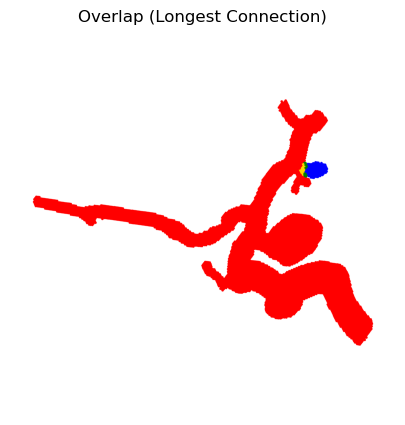


Largest Aneurysm: 2d_projection_no_overlap_angle_160.png
Saving No Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_2_saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_160.png
Saved No Overlap (Largest Aneurysm) successfully.


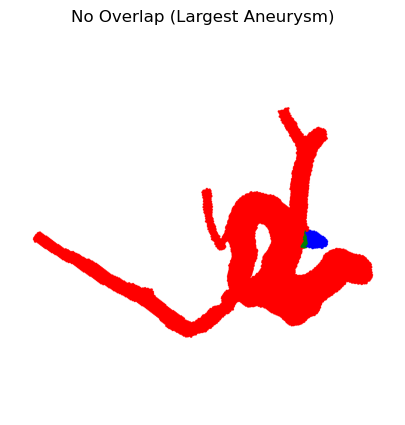

Saving Overlap (Largest Aneurysm) to: D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2\C0074_2_saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_160.png
Saved Overlap (Largest Aneurysm) successfully.


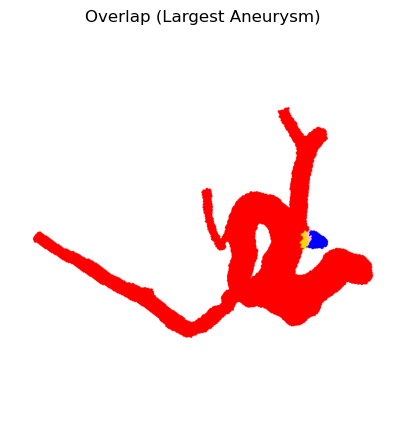

In [4]:
from PIL import Image
import os
import numpy as np
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

# List of folder numbers
folder_numbers = ['C0001','C0002','C0003','C0005','C0008','C0018','C0036','C0049','C0004_1','C0004_2','C0074_1','C0074_2']
base_folder_path = r"D:\Utrecht Studying\Team challenge\Aneurysm_TC_data\results_2"

# Define color ranges (in RGB format)
red_color = np.array([255, 0, 0])  # Blood vessels
green_color = np.array([0, 128, 0])  # Connection region
blue_color = np.array([0, 0, 255])  # Aneurysm
pink_color = np.array([255, 192, 203])  # Overlap between blood vessels and aneurysm
purple_color = np.array([128, 0, 128])  # Overlap between blood vessels and connection region

# Define color tolerance
tolerance = 50

def count_pixels_by_color(image, target_color, tolerance):
    """Count the pixels of a specific color in the image."""
    image_array = np.array(image)
    color_diff = np.abs(image_array - target_color)
    within_tolerance = np.all(color_diff <= tolerance, axis=-1)
    return np.sum(within_tolerance)

def evaluate_overlap_and_connection(image, connection_color, blood_vessel_color, tolerance=20):
    """Evaluate the overlap of connection region and blood vessel areas."""
    connection_pixels = count_pixels_by_color(image, connection_color, tolerance)
    blood_vessel_pixels = count_pixels_by_color(image, blood_vessel_color, tolerance)
    connection_blood_vessel_overlap = count_pixels_by_color(image, purple_color, tolerance)  # Overlap area
    
    # Handle the special case when connection_pixels is zero
    if connection_pixels == 0:
        if connection_blood_vessel_overlap > 0:
            connection_overlap_percentage = float('inf')  # Infinite overlap ratio
        else:
            connection_overlap_percentage = 0  # No overlap, no connection area
    else:
        connection_overlap_percentage = connection_blood_vessel_overlap / connection_pixels

    return connection_pixels, connection_blood_vessel_overlap, connection_overlap_percentage, blood_vessel_pixels


def process_images(folder_path, result_file):
    """Process images to identify the top 10 with minimal connection overlap, then select top 5 with minimal total overlap."""
    no_overlap_files = [f for f in os.listdir(folder_path) if '2d_projection_no_overlap_' in f and f.endswith('.png')]
    overlap_files = [f for f in os.listdir(folder_path) if '2d_projection_overlap_' in f and f.endswith('.png')]
    
    no_overlap_dict = {f.split('_')[-1].replace('.png', ''): f for f in no_overlap_files}
    overlap_dict = {f.split('_')[-1].replace('.png', ''): f for f in overlap_files}

    # Step 1: Calculate connection overlap percentage and select top 10 images with minimal connection overlap
    connection_overlap_list = []
    for angle, no_overlap_filename in no_overlap_dict.items():
        if angle in overlap_dict:
            overlap_filename = overlap_dict[angle]
            
            no_overlap_image = Image.open(os.path.join(folder_path, no_overlap_filename)).convert('RGB')
            overlap_image = Image.open(os.path.join(folder_path, overlap_filename)).convert('RGB')

            # Evaluate connection overlap
            connection_pixels, connection_blood_vessel_overlap, connection_overlap_percentage, blood_vessel_pixels = evaluate_overlap_and_connection(overlap_image, green_color, red_color)
            
            # Log the results
            result_file.write(f"File (no_overlap): {no_overlap_filename}\n")
            result_file.write(f"File (overlap): {overlap_filename}\n")
            result_file.write(f"connection_overlap_percentage: {connection_overlap_percentage}\n")
            result_file.write(f"connection_pixels: {connection_pixels}\n")
            result_file.write(f"connection_blood_vessel_overlap: {connection_blood_vessel_overlap}\n")
            result_file.write("-" * 30 + "\n")
            
            # Store connection overlap percentage and filenames
            connection_overlap_list.append((connection_overlap_percentage, no_overlap_filename, overlap_filename))

    # Sort by connection overlap percentage (ascending order)
    connection_overlap_list.sort(key=lambda x: x[0])
    top_10_min_connection_overlap = connection_overlap_list[:10]

    # Step 2: From the top 10, select top 5 with minimal total overlap (pink + purple)
    total_overlap_list = []
    for connection_overlap_percentage, no_overlap_filename, overlap_filename in top_10_min_connection_overlap:
        overlap_image = Image.open(os.path.join(folder_path, overlap_filename)).convert('RGB')
        pink_overlap_pixels = count_pixels_by_color(overlap_image, pink_color, tolerance)  # Overlap between blood vessels and aneurysm
        purple_overlap_pixels = count_pixels_by_color(overlap_image, purple_color, tolerance)  # Overlap between blood vessels and connection region
        total_overlap = pink_overlap_pixels + purple_overlap_pixels
        total_overlap_list.append((total_overlap, no_overlap_filename, overlap_filename))

    # Sort by total overlap (ascending order)
    total_overlap_list.sort(key=lambda x: x[0])
    top_10_min_total_overlap = total_overlap_list[:5]

    # Step 3: Apply final selection criteria
    # Criterion 1: Shortest connection region (smallest connection_pixels)
    shortest_connection = min(top_10_min_total_overlap, key=lambda x: count_pixels_by_color(Image.open(os.path.join(folder_path, x[1])).convert('RGB'), green_color, tolerance))

    # Criterion 2: Largest connection region (largest connection_pixels)
    longest_connection = max(top_10_min_total_overlap, key=lambda x: count_pixels_by_color(Image.open(os.path.join(folder_path, x[1])).convert('RGB'), green_color, tolerance))
 
    # Criterion 3: Largest aneurysm (largest blue pixels)
    largest_aneurysm = max(top_10_min_total_overlap, key=lambda x: count_pixels_by_color(Image.open(os.path.join(folder_path, x[1])).convert('RGB'), blue_color, tolerance))

    return shortest_connection, longest_connection, largest_aneurysm

def save_and_display_image(image, title, save_path, original_filename):
    """Save and display the image."""
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")

    safe_title = title.replace(' ', '_').replace(':', '').replace('/', '_')
    save_filename = original_filename.replace('2d_projection', safe_title)
    save_full_path = os.path.join(save_path, save_filename)

    print(f"Saving {title} to: {save_full_path}")
    plt.savefig(save_full_path, bbox_inches='tight', pad_inches=0, dpi=700)
    print(f"Saved {title} successfully.")
    plt.show()

def main(folder_number):
        
    folder_path = os.path.join(base_folder_path, folder_number + "_saved_images")
    if not os.path.exists(folder_path):
        print(f"Skipping: {folder_path} does not exist.")
        return
    
    save_optimal_path = os.path.join(folder_path, "optimal")
    if not os.path.exists(save_optimal_path):
        os.makedirs(save_optimal_path)

    with open(os.path.join(folder_path, 'results.txt'), 'w') as result_file:
        shortest_connection, longest_connection, largest_aneurysm = process_images(folder_path, result_file)

    # Dictionary of the best selections
    selections = {
        "Shortest Connection": shortest_connection,
        "Longest Connection": longest_connection,
        "Largest Aneurysm": largest_aneurysm
    }

    # Display and save optimal images
    for title, selection in selections.items():
        if selection:
            total_overlap, no_overlap_filename, overlap_filename = selection
            print(f"\n{title}: {no_overlap_filename}")

            # Load and display the no-overlap image
            no_overlap_image = mpimg.imread(os.path.join(folder_path, no_overlap_filename))
            save_and_display_image(no_overlap_image, f"No Overlap ({title})", save_optimal_path, no_overlap_filename)

            # Load and display the overlap image
            overlap_image = mpimg.imread(os.path.join(folder_path, overlap_filename))
            save_and_display_image(overlap_image, f"Overlap ({title})", save_optimal_path, overlap_filename)

if __name__ == "__main__":
    # Iterate through each folder and process the images
    for folder_number in folder_numbers:
        print(f"\nProcessing folder: {folder_number}")
        main(folder_number)
